In [42]:
import random, math, time, os, requests

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from PIL import Image, ImageDraw, ImageFont

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model = model.to(device)

Downloading: "https://github.com/facebookresearch/detr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


  0%|          | 0.00/232M [00:00<?, ?B/s]

In [6]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

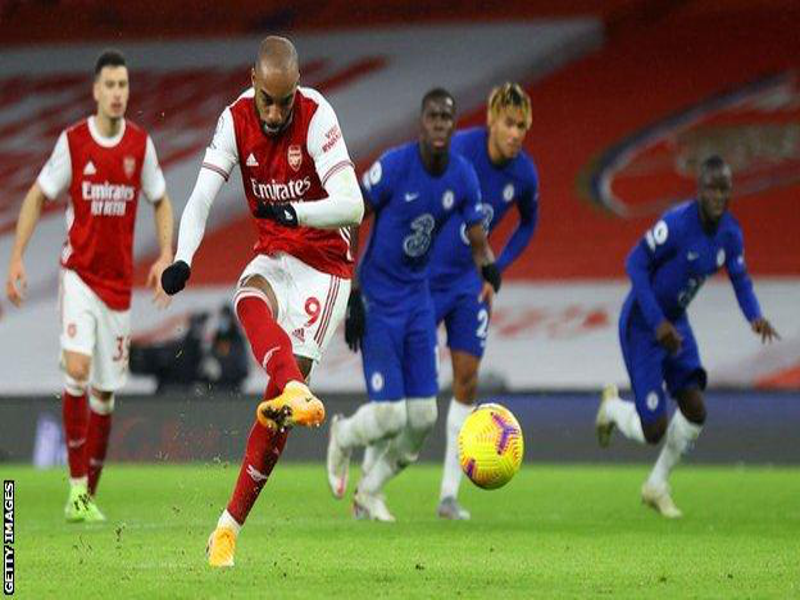

In [14]:
url = "https://ichef.bbci.co.uk/onesport/cps/624/cpsprodpb/122F6/production/_116268447_whatsubject.jpg"
img = Image.open(requests.get(url, stream=True).raw).resize((800,600)).convert('RGB')
img

In [15]:
input = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
  output = model(input)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [19]:
output.keys(), output['pred_logits'].shape, output['pred_boxes'].shape

(dict_keys(['pred_logits', 'pred_boxes']),
 torch.Size([1, 100, 92]),
 torch.Size([1, 100, 4]))

In [73]:
img2 = img.copy()
draw = ImageDraw.Draw(img2)
pred_logits=output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes=output['pred_boxes'][0]


max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(10)

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]

pred_logits.shape, pred_boxes.shape, len(CLASSES)

(torch.Size([10, 91]), torch.Size([10, 4]), 91)

In [74]:
for logits, box in zip(pred_logits, pred_boxes):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = CLASSES[cls]
  prob = max(logits.softmax(-1))
  print(label, prob)
  box = box.cpu() * torch.Tensor([800, 600, 800, 600])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  draw.rectangle([x0, y0, x1, y1], outline='red', width=5)

  font = ImageFont.load_default()
  
  prob = prob.detach().cpu().numpy()*100
  label += ": " + str(prob)[:2] + "%"
  draw.text((x0, y0), label, font=font)

person tensor(1.0000)
person tensor(1.0000)
person tensor(1.0000)
person tensor(1.0000)
person tensor(1.0000)
person tensor(0.9999)
person tensor(0.9999)
person tensor(0.9998)
sports ball tensor(0.9996)
person tensor(0.9991)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  # This is added back by InteractiveShellApp.init_path()


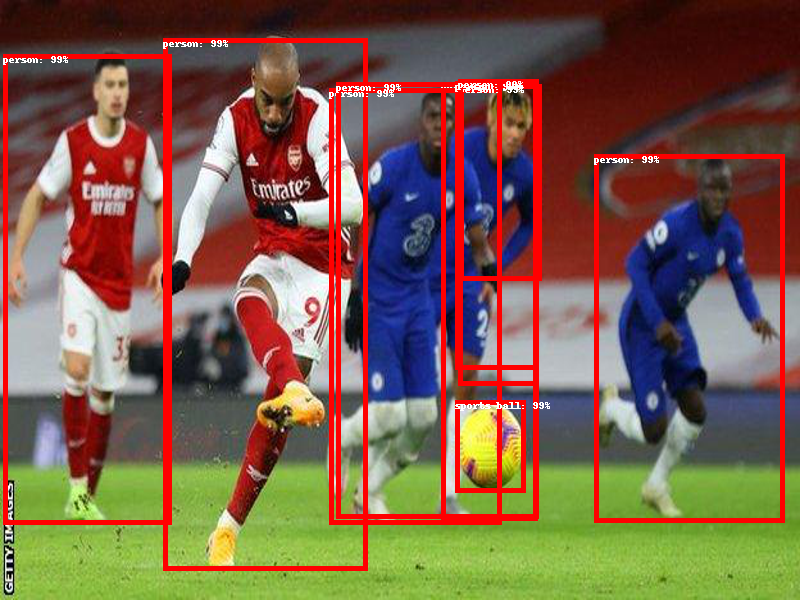

In [75]:
img2